In [108]:
import OffsetArrays
using DelimitedFiles
using Plots
using Revise
using StatsBase
using ProgressMeter
using SparseArrays, LinearAlgebra, IndexedGraphs, Graphs
using Distributions
srcpath = "./src"
include("$srcpath/bp.jl")
include("$srcpath/post_infer.jl")
include("$srcpath/observables.jl")
include("$srcpath/single_instance.jl")

build_real_graph (generic function with 1 method)

In [109]:
function δλ(infer_lam)
    if infer_lam
        return 0.001im
    else
        return 0.0
    end
end

δλ (generic function with 1 method)

In [110]:
# S=0   I=1
# The times go from ti = 0 to ti=T+1
# when ti=0 it means that i is the zero patient
# when ti=T+1 it means that i is never infected

λp = 0.03# planted infection rate
λi = 0.03 #inferred infection rate

infer_lam = false #set it true if you want to infere the prior parameter λ
infer_gam = false #set it true if you want to infere the prior parameter γ


T = 8 # discrete time

γp = 0.2 # planted autoinfection probability
γi = 0.2 # inferred autoinfection probability

N = 10000; #population size
dilution = 0.0
fr = 0.0;


In [111]:
#import empirical network
edges = readdlm("ia-escorts-dynamic.edges",Int,skipstart=2)[:,1:2];
G = build_real_graph(edges)
Ngraph = nv(G)

10106

# Population dynamics for the messages

In [112]:
#degree_dist = empirical_deg_distr(G) 
degree_dist = Poisson(3)
M = ParametricModel(N = N, T = T, γp = γp, λp = λp, γi=γi, λi=λi + δλ(infer_lam), fr=fr, dilution=dilution, distribution=degree_dist,field=0.0) ;

In [113]:
a = time()
M = ParametricModel(N = N, T = T, γp = γp, λp = λp, γi=γi, λi=λi + δλ(infer_lam), fr=fr, dilution=dilution, distribution=degree_dist,field=0.0) ;
unif_initializ!(M)
F,it = logpop_dynamics(M, tot_iterations = 10, eta = 0.1, infer_lam=infer_lam, infer_gam=infer_gam);
b = time()
F

10-element Vector{Float64}:
 1.5885694420933898
 1.5826195347975067
 1.576930609921171
 1.5854674737876544
 1.5934682429989713
 1.5737526387407677
 1.5669297481119546
 1.575982488537056
 1.5855032120208081
 1.5854766647694953

In [114]:
marg = M.belief |> real;
marg2D = reshape(sum(marg,dims=3) ./ N, T+2,T+2)

10×10 Matrix{Float64}:
 0.134324    0.00860482   0.00817446   …  0.00749303   0.00798579   0.0
 0.00756918  0.000968541  0.000939497     0.000672316  0.000717922  0.0
 0.00776504  0.00096797   0.000943728     0.000696794  0.000753213  0.0
 0.00795408  0.000963145  0.00094426      0.000720315  0.000788043  0.0
 0.00813511  0.000954111  0.00094106      0.000742828  0.000822488  0.0
 0.008307    0.000940894  0.000934098  …  0.000764288  0.000856678  0.0
 0.00846868  0.000923471  0.000923355     0.000784656  0.000890802  0.0
 0.00861919  0.000901717  0.000908851     0.000803884  0.000925117  0.0
 0.0087576   0.000875333  0.000890687     0.000821888  0.000959948  0.0
 0.0         0.0          0.0             0.0          0.0          0.6771

In [115]:
ensAUC = avgAUC(marg,M.obs_list,count_obs=true); #set false to see the AUC only on NON observed indiv.

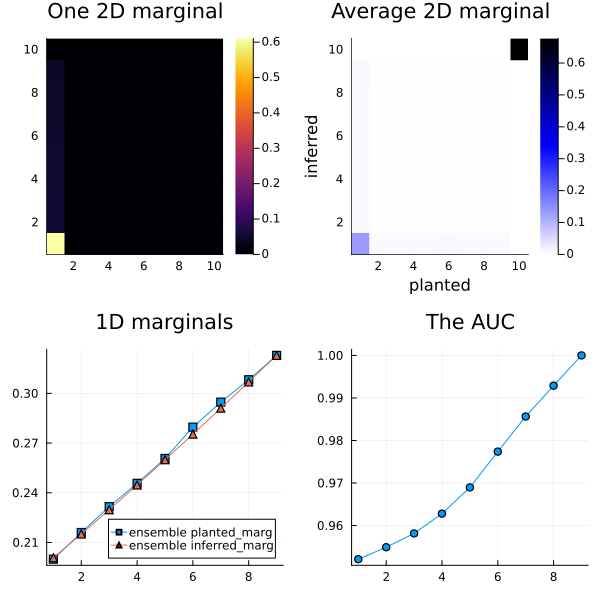

In [116]:
p1 = heatmap(reshape((marg[:,:,rand(1:N)]),T+2,T+2),title="One 2D marginal")
p2 = plot(ensAUC,label="ens_AUC",marker=:c,legend=false,title="The AUC")
pheat = heatmap((marg2D),c=[:white,:blue,:black],xlabel="planted",ylabel="inferred",title="Average 2D marginal")
p0 = plot(cumsum(sum(marg2D,dims=1)'[1:end-1],dims=1),marker=:square,label="ensemble planted_marg",title="1D marginals")
p0 = plot!(cumsum(sum(marg2D,dims=2)[1:end-1],dims=1),marker=:utriangle,label="ensemble inferred_marg",legend=:bottomright)
plot(p1,pheat,p0,p2,size=(600,600))

# Single Instance Inferernce with Sib

## General framework with disorder
Here the results of observations change because the parameter regime is non trivial. Therefore we need to sample a planted configuration, observe this configuration at final time and infere the single instance. We do this many times and we average so to compare with the ensemble results

### Check of the planted distribution
Here we check with a sampler and with sibyl that the planted ensemble marginal is correct.

In [117]:
include("$srcpath/single_instance.jl")

build_real_graph (generic function with 1 method)

In [118]:
#G = IndexedBiDiGraph(G)
Ngraph = 10
G = makeGraph(Ngraph,degree_dist)
x = zeros(Int,Ngraph, T + 1) # a single epidemic trajectory
# First we initialize a single instance marginal y
# which will be the average over graph and particles
# and epidemic trajectory of the marginals
y = zeros(T+1)
yBPp = zero(y)
# we average over totst iterations
totst = 1000

@showprogress for st = 1:totst
    # for every iteration we initialize a new graph
    # we sample an epidemic
    sample!(x, G, λp, γp)
    # we calculate the cumulative marginal (non-normalized)
    # and we sum it to the average marginal
    y .+= sum(x,dims=1)'
    p_sib = sibyl(Ngraph, T+1, G, [], γp, λp; maxit = 40, tol = 1e-2);
    avgmarg = sum(p_sib,dims=1)' ./ Ngraph
    yBPp .+= avgmarg
end
#we normalize the average marginal
y ./= (Ngraph * totst)
yBPp ./=  totst;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


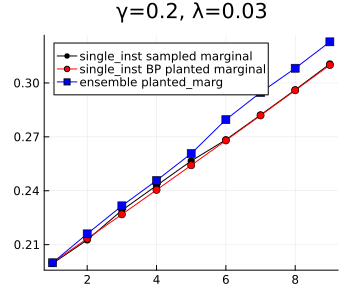

In [119]:
p0 = plot(y,c=:black,marker=:circle,label="single_inst sampled marginal",title="γ=$γp, λ=$λp")
p0 = plot!(yBPp,c=:red,marker=:circle,label="single_inst BP planted marginal")
p0 = plot!(cumsum(sum(marg2D,dims=1)'[1:end-1],dims=1),c=:blue,marker=:square,size=(350,300),label="ensemble planted_marg",legend=:topleft)

### Comparison between inference (sibyl) and ensemble results
Here we check instead the results for the inferred marginal

In [120]:
yBP = zeros(T+1)
yBPerr = zero(yBP)
totst = 1000
λinfer = zeros(totst)
γinfer = zeros(totst)
@showprogress for st = 1:totst
    # for every iteration we initialize a new graph
    # we sample an epidemic
    sample!(x, G, λp, γp)
    # observations set in the form of 
    # [(individual,state,observation time, false_rate of the test)]
    # where state ∈ {0,1} respectively for S and I
    # The reason why there is a T+1 is that sibyl starts from time 1 to time T. 
    # Instead the ensemble goes from time 0 to time T  
    O = [(i,Bool(x[i,T+1]),T+1,1e-10) for i = 1:Int(round(Ngraph * (1 - dilution)))]
    O = [rand() > fr ? (o[1],o[2],o[3],fr) : (o[1],!o[2],o[3],fr) for o in O]
    #we now run the BP algorithm for the single instance defined above
    p_sib = sibyl(Ngraph, T+1, G, O,  γi , λi; maxit = 200, tol = 1e-2);
    yBP .+= sum(p_sib,dims=1)'
    yBPerr .+= sum(p_sib ,dims=1)' .^ 2
end

yBP ./= (Ngraph * totst);
#yBPerr ./= (Ngraph^2 * totst)
#yBPerr .= sqrt.(yBPerr .- yBP .^ 2) / sqrt(totst)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


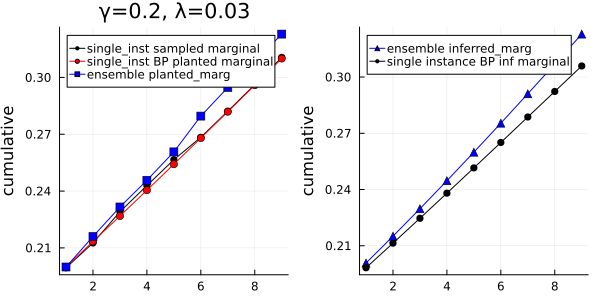

In [121]:
p1 = plot(cumsum(sum(marg2D,dims=2),dims=1)[1:end-1],c=:blue,marker=:utriangle,label="ensemble inferred_marg",legend=:bottomright)
p1 = plot!(yBP,c=:black,marker=:circle,label="single instance BP inf marginal")
plot(p0,p1,size=(600,300),ylabel="cumulative",legend=:topleft)
#savefig("sibVSepid")

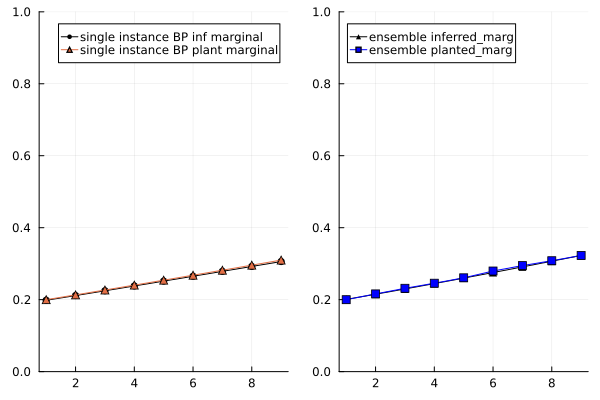

In [122]:
p2 = plot(yBP,c=:black,marker=:circle,label="single instance BP inf marginal")
p2 = plot!(yBPp,marker=:utriangle,label="single instance BP plant marginal")
p3 = plot(cumsum(sum(marg2D,dims=2),dims=1)[1:end-1],c=:black,marker=:utriangle,label="ensemble inferred_marg",legend=:bottomright)
p3 = plot!(cumsum(sum(marg2D,dims=1)'[1:end-1],dims=1),c=:blue,marker=:square,size=(350,300),label="ensemble planted_marg",legend=:topleft)
plot(p2,p3,ylim=(0,1))

## 2D marginal comparison

In [123]:
function pdf(cdf_sib)
    N, T = size(cdf_sib) 
    p = zeros(N,T+1)
    p[:,1] .= cdf_sib[:,1]
    for t = 1:T-1
        p[:,t+1] .= cdf_sib[:,t+1] .- cdf_sib[:,t]
    end
    p[:,T+1] .= 1 .- cdf_sib[:,T]
    return p
end

pdf (generic function with 1 method)

In [157]:
AUC = zeros(T+1)
AUCerr = zeros(T+1)
AUC =  zeros(T+1)
sibylmarg2D = zeros(T+2,T+2)
totst = 1000
mse = zeros(totst,T+1)
@showprogress for st = 1:totst
    sample!(x, G, λp, γp)
    O = [(i,Bool(x[i,T+1]),T+1,1e-10) for i = 1:Int(round(Ngraph * (1 - dilution)))]
    O = [rand() > fr ? (o[1],o[2],o[3],fr) : (o[1],!o[2],o[3],fr) for o in O]
    p_sib = sibyl(Ngraph, T+1, G, O, γi, λi; maxit = 40, tol = 1e-100);
    sib_pdf = pdf(p_sib)
    mse[st,:] .+= siMSE(x, p_sib)
    for t = 1:T+1
        AUC[t] += AUROC(ROC(x[:,t], p_sib[:,t]))
        AUCerr[t] += AUROC(ROC(x[:,t], p_sib[:,t]))^2
    end
    tau = T .- sum(x,dims=2) .+ 2; #set of planted times
    for τ = 1:T+2
        # We take the pdf only for individuals infected at time τ 
        sibylmarg2D[:,τ] .+= sum(sib_pdf .* (tau .== τ ),dims=1)' 
    end
    sing_inst_marg = zeros(Ngraph, T+2, T+2)
    for l = 1:Ngraph
        sing_inst_marg[l,:,tau[l]] .= sib_pdf[l,:] 
    end
    sing_inst_marg = OffsetArrays.OffsetArray(sing_inst_marg,0,-1,-1);
    #AUCens = avgAUC(sing_inst_marg)
end
AUC ./= totst 
AUCerr .= sqrt.((AUCerr./ totst  .- (AUC .^ 2))./ totst ) 
sibylmarg2D ./= (Ngraph*totst);



Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


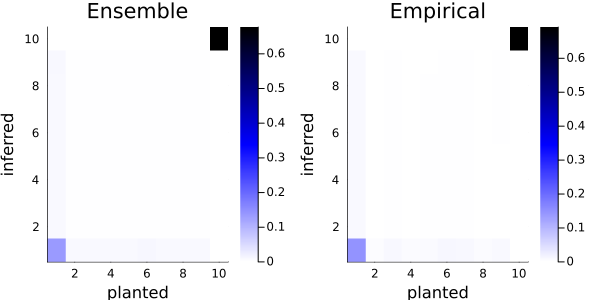

In [155]:
plot_sib = heatmap(sibylmarg2D,c=[:white,:blue,:black],xlabel="planted",ylabel="inferred",title="Empirical")
plot_ens = heatmap(marg2D,c=[:white,:blue,:black],xlabel="planted",ylabel="inferred",title="Ensemble")
plot(plot_ens,plot_sib,size=(600,300))

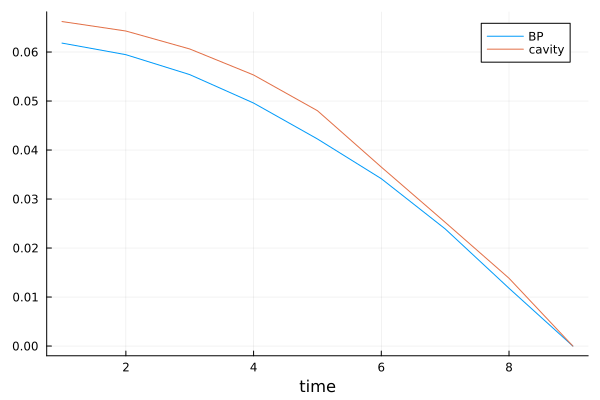

In [158]:
plot((sum(mse,dims=1)./totst)',label = "BP",xlabel="time")
plot!(MSE(marg), label = "cavity")

In [146]:
size(mse)

(9,)

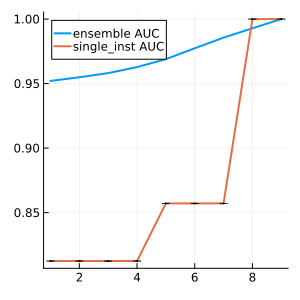

In [139]:
pAUC = plot(ensAUC,label="ensemble AUC",w=2)
pAUC = plot!(AUC,label="single_inst AUC",w=2,legend=:topleft,yerr=AUCerr,size=(300,300))
#savefig("ensemble_VS_sibyl")

In [127]:
AUC

9-element Vector{Float64}:
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

# A study on variation of $\lambda$\lambda